In [71]:
# basic
import os
import datetime
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

# torch
import torch.autograd as autograd
import torch.optim as optim
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader

# other
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error


# GAN
## originally

* multiple versions of the model **WGAN-GP + L1 + FFT loss**.
* The best model came out with `lambda_l1 = 20`, `epochs = 70`.
* However, some experiments performed poorly: **15, 17, 18** had very low correlation (Corr < 0.6).
* In the plots it was clear that the generator failed to reproduce the real signals for these cases (esp. experiment 15 was way off, almost flat).

---

##  “improved algorithm”

### 1. **Identify problematic experiments**

* After validation -->  selected experiments with Corr < 0.6.
* The problematic set was **{15, 17, 18}**.
* These were the experiments the generator failed to learn.

--> **Goal:** specifically improve generator performance on these cases.

---

### 2. **Re-use the best model**

* Instead of training from scratch, loaded the best model we already had.
* fine-tuned it with adjusted training settings.

--> **fine-tuning**

---

### 3. **Weighted L1 loss for problematic experiments**

* In the original code, all samples contributed equally to the L1 loss.
* In the new version, introduced **per-experiment weighting**:

  ```python
  weights = torch.ones(b_size, device=device)
  if problematic_exps is not None:
      for i, exp_id in enumerate(exp_ids):
          if int(exp_id.item()) in problematic_exps:
              weights[i] = 2.0  # double the weight
  l1_loss = (l1_loss * weights).mean()
  ```
* This means samples from experiments 15, 17, 18 contributed more strongly to the loss --> The model was forced to learn them better.

---

### 4. **Keep the combined loss structure**

The generator loss combined three terms:

1. **Adversarial loss (WGAN)** – ensures generated signals look realistic.
2. **Weighted L1 loss** – ensures generated signals match the real shapes.
3. **FFT loss** – ensures generated signals have the correct frequency spectrum.

```python
loss_G = adv_loss + lambda_l1 * l1_loss + lambda_fft * fft_loss
```

--> This combination enforces both **time-domain shape** and **frequency-domain consistency**.

---

### 5. **Logging and saving**

* During training we stored: `loss_D`, `loss_G`, `lambda_l1`, `lambda_fft`.
* After fine-tuning we saved everything into a new folder (`results_biggerL1/...`).
* Validation metrics, real and generated signals, and plots were also saved.

--> This allowed a direct **old vs. new model comparison**.

---

### 6. **Comparison: old vs. new**

* We compared validation statistics (`MSE`, `Corr`).
* Results:

  * Old average Corr ≈ 0.90
  * New average Corr ≈ 0.98
* Then we checked only problematic experiments:

  * **17 and 18 improved significantly** (Corr much higher, realistic signals).
  * **15 remained problematic** — the generator still outputs almost a flat line.

---

## Summary (what the improved algorithm does)

1. **Detect weaknesses** (experiments with poor correlation).
2. **Load the best previous model**.
3. **Fine-tune with weighted L1 loss** for problematic experiments.
4. **Keep FFT loss** to preserve spectral properties.
5. **Validate and compare** old vs. new performance.
6. Check whether problematic experiments improved.



---
### `Signal1DDataset`

A custom PyTorch `Dataset` for loading 1D signal data (stored in CSV files) together with experimental conditions.

#### Features:

* **Initialization (`__init__`)**

  * Reads metadata from a CSV (`params_csv`).
  * Filters experiments if `allowed_experiments` is provided.
  * Collects all signal file paths (`.csv`), their associated experimental conditions, and experiment IDs.
  * Optionally computes **global normalization** values for signals (min/max) and conditions (mean/std).

* **`__len__`**

  * Returns the total number of available samples.

* **`__getitem__`**

  * Loads a signal from its `.csv` file.
  * Extracts the signal values (from `"intensity"` column if present, otherwise last column).
  * Normalizes the signal globally to the range **[-1, 1]** if enabled.
  * Normalizes condition values (z-score) if enabled.
  * Returns a tuple:

    * `signal` → `torch.FloatTensor` of signal values
    * `cond` → `torch.FloatTensor` of condition values
    * `exp_id` → `torch.LongTensor` experiment ID


In [72]:
# ==========================
# Dataset
# ==========================
class Signal1DDataset(Dataset):
    def __init__(self, root_dir, params_csv, allowed_experiments=None,
                 normalize_signals=True, normalize_conditions=True):
        self.root_dir = root_dir
        self.params_df = pd.read_csv(params_csv)

        if allowed_experiments is not None:
            self.params_df = self.params_df[self.params_df["experiment"].isin(allowed_experiments)]

        self.samples = []
        for _, row in self.params_df.iterrows():
            folder_id = str(int(row["experiment"]))
            folder_path = os.path.join(root_dir, folder_id)
            if not os.path.isdir(folder_path):
                continue
            for fname in os.listdir(folder_path):
                if fname.lower().endswith(".csv"):
                    fpath = os.path.join(folder_path, fname)
                    conditions = row.drop("experiment").values
                    exp_id = int(row["experiment"])
                    self.samples.append((fpath, conditions, exp_id))

        print(f"Loaded {len(self.samples)} files (experiments={allowed_experiments})")

        # === signal normalization ===
        self.normalize_signals = normalize_signals
        if normalize_signals and len(self.samples) > 0:
            all_signals = []
            for fpath, _, _ in self.samples:
                df = pd.read_csv(fpath)
                if "intensity" in df.columns:
                    sig = df["intensity"].values.astype(np.float32)
                else:
                    sig = df.iloc[:, -1].values.astype(np.float32)
                all_signals.append(sig)

            all_signals = np.concatenate(all_signals)
            self.global_min = all_signals.min()
            self.global_max = all_signals.max()
            print(f"Global normalization: min={self.global_min:.4f}, max={self.global_max:.4f}")

        # === condition normalization ===
        self.normalize_conditions = normalize_conditions
        if normalize_conditions and len(self.samples) > 0:
            all_conditions = np.stack([s[1] for s in self.samples])
            self.cond_mean = all_conditions.mean(axis=0)
            self.cond_std = all_conditions.std(axis=0)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        signal_path, cond, exp_id = self.samples[idx]
        df = pd.read_csv(signal_path)

        if "intensity" in df.columns:
            signal = df["intensity"].values.astype(np.float32)
        else:
            signal = df.iloc[:, -1].values.astype(np.float32)

        if self.normalize_signals:
            signal = (signal - self.global_min) / (self.global_max - self.global_min + 1e-8)
            signal = signal * 2.0 - 1.0  # range [-1, 1]

        cond = cond.astype(np.float32)
        if self.normalize_conditions:
            cond = (cond - self.cond_mean) / (self.cond_std + 1e-8)

        return torch.from_numpy(signal), torch.from_numpy(cond), torch.tensor(exp_id, dtype=torch.long)



### `Generator1D`

A conditional generator for 1D signals.

* **Input:**

  * Random noise vector (`noise_dim`)
  * Conditioning vector (`cond_dim`)
* **Architecture:**

  * Fully connected layers with ReLU activations.
  * Output mapped to length `signal_len`.
  * Final activation: `Tanh()` → ensures signal values are in **[-1, 1]**.
* **Output:**

  * Generated 1D signal conditioned on `cond`.

---

### `Discriminator1D`

A conditional discriminator for 1D signals.

* **Input:**

  * Signal of length `signal_len`
  * Conditioning vector (`cond_dim`)
* **Architecture:**

  * 1D convolutional layers extract local features from the signal.
  * Flattened features concatenated with condition vector.
  * Fully connected layers with LeakyReLU and dropout.
  * Final linear layer outputs a single scalar (real/fake score).
* **Output:**

  * Real/fake classification score (no activation → usable with Wasserstein loss).

---

### Custom Loss Functions

#### `fft_loss(real, fake)`

* Computes **spectral similarity** between real and generated signals.
* Uses **FFT magnitudes** (ignores phase).
* Returns mean absolute difference in frequency domain.

#### `gradient_penalty(D, real_data, fake_data, cond, ...)`

* Implements **gradient penalty** for Wasserstein GAN with GP (WGAN-GP).
* Interpolates between real and fake samples.
* Enforces Lipschitz constraint by penalizing gradient norm deviation from 1.

---

* **Generator1D** produces synthetic 1D signals conditioned on experiment parameters.
* **Discriminator1D** distinguishes real vs. fake signals while using conditions.
* **fft_loss** encourages spectral similarity.
* **gradient_penalty** stabilizes GAN training (WGAN-GP).

---


In [ ]:
# ==========================
# Generator
# ==========================
class Generator1D(nn.Module):
    def __init__(self, noise_dim=64, cond_dim=5, signal_len=450):
        super().__init__()
        input_dim = noise_dim + cond_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, signal_len),
            nn.Tanh()
        )
    def forward(self, noise, cond):
        x = torch.cat([noise, cond], dim=1)
        return self.net(x)


# ==========================
# Discriminator
# ==========================
class Discriminator1D(nn.Module):
    def __init__(self, cond_dim=5, signal_len=450):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, stride=2, padding=3),
            nn.LeakyReLU(0.2),
            nn.Conv1d(16, 32, kernel_size=7, stride=2, padding=3),
            nn.LeakyReLU(0.2),
            nn.Conv1d(32, 64, kernel_size=7, stride=2, padding=3),
            nn.LeakyReLU(0.2),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, signal_len)
            out = self.feature_extractor(dummy)
            flat_dim = out.view(1, -1).size(1)

        self.fc1 = nn.Linear(flat_dim + cond_dim, 128)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(128, 1)

    def forward(self, signal, cond):
        x = signal.unsqueeze(1)       # (B, 1, L)
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)     # flatten
        x = torch.cat([x, cond], dim=1)
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)
        return self.out(x)


# ==========================
# Lossy
# ==========================
def fft_loss(real, fake):
    real_fft = torch.fft.rfft(real, dim=1)
    fake_fft = torch.fft.rfft(fake, dim=1)
    return torch.mean(torch.abs(torch.abs(real_fft) - torch.abs(fake_fft)))


def gradient_penalty(D, real_data, fake_data, cond, device="cpu", lambda_gp=10):
    b_size = real_data.size(0)
    alpha = torch.rand(b_size, 1, device=device)
    alpha = alpha.expand_as(real_data)

    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    d_interpolates = D(interpolates, cond)

    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(b_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    gp = ((gradient_norm - 1) ** 2).mean() * lambda_gp
    return gp

### `train_wgan_gp_l1_advanced`

A training loop for **conditional WGAN-GP** on 1D signals, extended with **L1 reconstruction loss** and **FFT loss** for better signal quality.

---

#### Training Procedure:

1. **Discriminator Update (n_critic times)**

   * Generate fake signals with Generator.
   * Compute Discriminator outputs on real and fake signals.
   * Apply **gradient penalty** to enforce Lipschitz constraint.
   * Update Discriminator.

2. **Generator Update**

   * Generate fake signals.
   * Compute adversarial loss (`-D(fake)`).
   * Compute **weighted L1 loss** (optionally up-weighting problematic experiments).
   * Compute **FFT loss** (spectral difference).
   * Combine into total loss:
     [
     L_G = L_{adv} + \lambda_{L1} \cdot L_{L1} + \lambda_{FFT} \cdot L_{FFT}
     ]
   * Update Generator.

3. **Logging**

   * Collect average Discriminator and Generator losses per epoch.
   * Track `lambda_l1` and `lambda_fft`.
   * Print progress each epoch.

---

#### Returns:

* **history** (`dict`) containing lists per epoch:

  * `loss_D` – Discriminator loss.
  * `loss_G` – Generator loss.
  * `lambda_l1` – Current value of λL1.
  * `lambda_fft` – Current value of λFFT.

---



In [73]:
def train_wgan_gp_l1_advanced(
    G, D, train_loader, noise_dim, num_epochs=50,
    lr_G=1e-4, lr_D=5e-5, device="cpu",
    n_critic=2, lambda_gp=1.0,
    lambda_l1=10.0, lambda_fft=2.0,
    l1_decay_every=None,
    problematic_exps=None
):
    optimizer_G = optim.Adam(G.parameters(), lr=lr_G, betas=(0.0, 0.9))
    optimizer_D = optim.Adam(D.parameters(), lr=lr_D, betas=(0.0, 0.9))

    history = {"loss_D": [], "loss_G": [], "lambda_l1": [], "lambda_fft": []}

    for epoch in range(num_epochs):
        loss_D_epoch, loss_G_epoch = 0.0, 0.0

        if l1_decay_every is not None and (epoch > 0) and (epoch % l1_decay_every == 0):
            lambda_l1 = lambda_l1 / 2.0
            print(f"[Epoch {epoch}] Snižuji lambda_l1 → {lambda_l1}")

        for signals, conds, exp_ids in train_loader:
            signals = signals.to(device).float()
            conds = conds.to(device).float()
            exp_ids = exp_ids.to(device)
            b_size = signals.size(0)

            # Discriminator
            for _ in range(n_critic):
                noise = torch.randn(b_size, noise_dim, device=device)
                fake_signals = G(noise, conds)

                D.zero_grad()
                real_validity = D(signals, conds)
                fake_validity = D(fake_signals.detach(), conds)

                gp = gradient_penalty(D, signals, fake_signals, conds, device, lambda_gp)
                loss_D = fake_validity.mean() - real_validity.mean() + gp

                loss_D.backward()
                optimizer_D.step()

            # Generator
            noise = torch.randn(b_size, noise_dim, device=device)
            fake_signals = G(noise, conds)

            G.zero_grad()
            fake_validity = D(fake_signals, conds)

            adv_loss = -fake_validity.mean()

            # vážený L1
            weights = torch.ones(b_size, device=device)
            if problematic_exps is not None:
                for i, exp_id in enumerate(exp_ids):
                    if int(exp_id.item()) in problematic_exps:
                        weights[i] = 2.0
            l1_loss = F.l1_loss(fake_signals, signals, reduction="none").mean(dim=1)
            l1_loss = (l1_loss * weights).mean()

            # FFT loss
            fft_l = fft_loss(signals, fake_signals)

            # total loss
            loss_G = adv_loss + lambda_l1 * l1_loss + lambda_fft * fft_l

            loss_G.backward()
            optimizer_G.step()

            loss_D_epoch += loss_D.item()
            loss_G_epoch += loss_G.item()

        loss_D_epoch /= len(train_loader)
        loss_G_epoch /= len(train_loader)
        history["loss_D"].append(loss_D_epoch)
        history["loss_G"].append(loss_G_epoch)
        history["lambda_l1"].append(lambda_l1)
        history["lambda_fft"].append(lambda_fft)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss_D: {loss_D_epoch:.4f} Loss_G: {loss_G_epoch:.4f} "
              f"(λL1={lambda_l1:.2f}, λFFT={lambda_fft:.2f})")

    return history


### `validate_and_save_all`


1. Set **Generator to eval mode** (`G.eval()`).
2. Loop through all dataset samples:

   * Get real signal and condition vector.
   * Generate fake signal from random noise + condition.
   * Compute **MSE** (Mean Squared Error) between real and fake.
   * Compute **Pearson correlation** between real and fake.
   * Store metrics and signals.
3. Save results to disk:

   * `validation_metrics{suffix}.csv` → per-sample MSE and correlation.
   * `real_signals{suffix}.npy` → NumPy array of all real signals.
   * `fake_signals{suffix}.npy` → NumPy array of all generated signals.
4. Plot histograms:

   * Distribution of MSE across samples.
   * Distribution of correlations across samples.
   * Save as `validation_metrics_hist{suffix}.png`.

---

#### Returns:

* **df (pandas.DataFrame)** with columns:

  * `idx` – sample index
  * `MSE` – reconstruction error
  * `Corr` – Pearson correlation coefficient

---

This function provides a **quantitative and qualitative evaluation** of the Generator by comparing generated signals against the full validation dataset, then saving both metrics and visualizations for later inspection.



In [74]:
def validate_and_save_all(G, dataset, noise_dim=64, device="cpu", save_dir="results", epoch=None):
    """
    Vyhodnotí generátor na celé validační sadě.
    Uloží výsledky (MSE, Corr) + reálné/generované signály.
    Pokud je zadán parametr epoch -> přidá se do názvu souboru.
    """
    G.eval()
    all_results = []
    real_signals, fake_signals = [], []

    for idx in range(len(dataset)):
        sample = dataset[idx]
        if len(sample) == 3:   # (signal, cond, exp_id)
            real_signal, cond, exp_id = sample
        else:                  # (signal, cond)
            real_signal, cond = sample

        real_signal_np = real_signal.numpy()

        cond = cond.unsqueeze(0).to(device).float()
        noise = torch.randn(1, noise_dim, device=device)

        with torch.no_grad():
            fake_signal = G(noise, cond).cpu().numpy().flatten()

        mse = mean_squared_error(real_signal_np, fake_signal)
        corr, _ = pearsonr(real_signal_np, fake_signal)

        all_results.append({"idx": idx, "MSE": mse, "Corr": corr})
        real_signals.append(real_signal_np)
        fake_signals.append(fake_signal)

    df = pd.DataFrame(all_results)

    # --- dynamické názvy souborů podle epochy ---
    suffix = f"_epoch{epoch}" if epoch is not None else ""
    df.to_csv(os.path.join(save_dir, f"validation_metrics{suffix}.csv"), index=False)

    np.save(os.path.join(save_dir, f"real_signals{suffix}.npy"), np.array(real_signals))
    np.save(os.path.join(save_dir, f"fake_signals{suffix}.npy"), np.array(fake_signals))

    # histogramy
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(df["MSE"], bins=30, color="skyblue", edgecolor="black")
    plt.title("Distribuce MSE")
    plt.xlabel("MSE"); plt.ylabel("Počet vzorků")

    plt.subplot(1,2,2)
    plt.hist(df["Corr"], bins=30, color="salmon", edgecolor="black")
    plt.title("Distribuce korelace")
    plt.xlabel("Pearson corr"); plt.ylabel("Počet vzorků")

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"validation_metrics_hist{suffix}.png"), dpi=200)
    plt.close()

    return df


1. **Setup**

   * Define directories (`root_dir`, `results_dir`, `new_results_dir`).
   * Load dataset split (`train`, `val`) from `dataset_split.csv`.
   * Initialize `Signal1DDataset` for training and validation.
   * Detect device (`CPU`/`CUDA`).

2. **Dataset & Model Parameters**

   * Infer `signal_len` and `cond_dim` from the dataset.
   * Load the best previous run configuration (`config.json`).

3. **Model Initialization**

   * Create `Generator1D` and `Discriminator1D`.
   * Define problematic experiments (up-weighted in L1 loss).

4. **Training**

   * Run `train_wgan_gp_l1_advanced` with loaded hyperparameters.
   * Save training history (`.csv`, `.json`), model weights (`.pth`), and loss curve (`.png`).

5. **Validation**

   * Evaluate the new model with `validate_and_save_all`.
   * Save metrics, signals, and histograms.

6. **Comparison**

   * If metrics from the previous best run exist, compare **MSE** and **Correlation** distributions.

---

#### Outputs:

* Training history (`training_history.csv`, `training_history.json`)
* Model weights (`generator.pth`, `discriminator.pth`)
* Loss curve (`loss_curve.png`)
* Validation metrics (`validation_metrics*.csv`, `.npy`, `.png`)
* Console logs with training progress and performance comparison


In [75]:
if __name__ == "__main__":

    root_dir = "1D_spec"
    params_csv = os.path.join(root_dir, "params.csv")
    results_dir = "results02"
    new_results_dir = "results_biggerL1"
    os.makedirs(new_results_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # ==========================
    # Split 
    # ==========================
    split_file = os.path.join(results_dir, "dataset_split.csv")
    split_df = pd.read_csv(split_file)
    train_exps = split_df.query("set == 'train'")["experiment"].tolist()
    val_exps   = split_df.query("set == 'val'")["experiment"].tolist()

    train_dataset = Signal1DDataset(root_dir, params_csv, allowed_experiments=train_exps)
    val_dataset   = Signal1DDataset(root_dir, params_csv, allowed_experiments=val_exps)
    train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # ==========================
    # Signal dimensions
    # ==========================
    signal, cond, exp_id = train_dataset[0]
    noise_dim = 64
    cond_dim = cond.numel()
    signal_len = signal.numel()

    # ==========================
    # Load best run
    # ==========================
    best_run = "results02/lambda20_epochs70_20250927_011649"
    config_path = os.path.join(best_run, "config.json")
    with open(config_path, "r") as f:
        best_config = json.load(f)

    print("Loaded best run:", best_run)
    print("Configuration:", best_config)

    # ==========================
    # Models
    # ==========================
    G = Generator1D(noise_dim=noise_dim, cond_dim=cond_dim, signal_len=signal_len).to(device)
    D = Discriminator1D(cond_dim=cond_dim, signal_len=signal_len).to(device)

    problematic_exps = {15, 17, 18}

    # ==========================
    # Training
    # ==========================
    run_name = f"best_retrain_fft_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
    run_dir = os.path.join(new_results_dir, run_name)
    os.makedirs(run_dir, exist_ok=True)

    history = train_wgan_gp_l1_advanced(
        G, D, train_loader, noise_dim,
        num_epochs=best_config["num_epochs"],
        device=device,
        lr_G=best_config["lr_G"], lr_D=best_config["lr_D"],
        n_critic=best_config["n_critic"],
        lambda_gp=best_config["lambda_gp"],
        lambda_l1=best_config["lambda_l1"],
        lambda_fft=2.0,
        problematic_exps=problematic_exps
    )

    # ==========================
    # Save results
    # ==========================
    pd.DataFrame(history).to_csv(os.path.join(run_dir, "training_history.csv"), index=False)
    with open(os.path.join(run_dir, "training_history.json"), "w") as f:
        json.dump(history, f)

    torch.save(G.state_dict(), os.path.join(run_dir, "generator.pth"))
    torch.save(D.state_dict(), os.path.join(run_dir, "discriminator.pth"))

    plt.figure(figsize=(8, 5))
    plt.plot(history["loss_D"], label="Discriminator")
    plt.plot(history["loss_G"], label="Generator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Progress (WGAN-GP + L1 + FFT)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(run_dir, "loss_curve.png"), dpi=200)
    plt.close()

    # ==========================
    # Validation of new model
    # ==========================
    val_df_new = validate_and_save_all(
        G, val_dataset, noise_dim=noise_dim,
        device=device, save_dir=run_dir
    )

    print("=== New model ===")
    print(val_df_new.describe()[["MSE", "Corr"]])

    # ==========================
    # Comparison with the best run
    # ==========================
    prev_metrics_path = os.path.join(best_run, "validation_metrics_epoch30.csv")
    if os.path.exists(prev_metrics_path):
        val_df_prev = pd.read_csv(prev_metrics_path)
        print("\n=== Previous best model ===")
        print(val_df_prev.describe()[["MSE", "Corr"]])

        print("\n=== Comparison ===")
        print(f"New avg MSE:  {val_df_new['MSE'].mean():.4f} vs. Old: {val_df_prev['MSE'].mean():.4f}")
        print(f"New avg Corr: {val_df_new['Corr'].mean():.4f} vs. Old: {val_df_prev['Corr'].mean():.4f}")
    else:
        print("Could not find metrics file from the previous best run.")


Using device: cpu
Loaded 991 files (experiments=[1, 14, 9, 2, 16, 6, 21, 12, 4, 5, 18, 13, 19, 17, 3, 10, 22])
Global normalization: min=0.0015, max=6.9025
Loaded 288 files (experiments=[8, 11, 15, 20, 7])
Global normalization: min=0.0039, max=3.2035
Loaded best run: results02/lambda20_epochs70_20250927_011649
Configuration: {'lambda_l1': 20, 'num_epochs': 70, 'lr_G': 0.0001, 'lr_D': 5e-05, 'n_critic': 2, 'lambda_gp': 1.0, 'noise_dim': 64, 'cond_dim': 5, 'signal_len': 450, 'device': 'cpu'}


KeyboardInterrupt: 

In [86]:
def compare_problematic_experiments(
    old_metrics_path, new_metrics_path,
    val_dataset, train_dataset,
    problematic={15, 17, 18}
):
    """
    Compare old vs. new model performance on problematic experiments.
    If an experiment is not in the validation set, it falls back to the training set.
    
    Parameters
    ----------
    old_metrics_path : str
        Path to CSV with validation metrics from the old model.
    new_metrics_path : str
        Path to CSV with validation metrics from the new model.
    val_dataset : Dataset
        Validation dataset (Signal1DDataset).
    train_dataset : Dataset
        Training dataset (Signal1DDataset).
    problematic : set of int
        Experiment IDs to check (default={15,17,18}).
    """

    df_old = pd.read_csv(old_metrics_path)
    df_new = pd.read_csv(new_metrics_path)

    # build mapping idx -> exp_id for both datasets
    idx_to_exp_val = {i: int(val_dataset[i][2].item()) for i in range(len(val_dataset))}
    idx_to_exp_train = {i: int(train_dataset[i][2].item()) for i in range(len(train_dataset))}

    results = {}

    for exp_id in problematic:
        # --- check validation set first ---
        val_indices = [i for i, eid in idx_to_exp_val.items() if eid == exp_id]
        if len(val_indices) > 0:
            df_old_sel = df_old[df_old["idx"].isin(val_indices)]
            df_new_sel = df_new[df_new["idx"].isin(val_indices)]
            dataset_name = "val"
        else:
            # --- fallback to training set ---
            train_indices = [i for i, eid in idx_to_exp_train.items() if eid == exp_id]
            if len(train_indices) > 0:
                # metrics are not saved for train set → can't compare directly
                print(f"Experiment {exp_id} found only in training set → skipping metrics comparison.")
                continue
            else:
                print(f"Experiment {exp_id} not found in validation or training set!")
                continue

        if len(df_old_sel) == 0 or len(df_new_sel) == 0:
            print(f"Experiment {exp_id} is in {dataset_name} set but missing in metrics CSV → skipping.")
            continue

        # --- aggregate results ---
        res_old = df_old_sel[["MSE", "Corr"]].mean()
        res_new = df_new_sel[["MSE", "Corr"]].mean()

        results[exp_id] = {"old": res_old, "new": res_new, "set": dataset_name}

        # --- print comparison ---
        print(f"\n=== Experiment {exp_id} ({dataset_name} set) ===")
        print("Old model:\n", res_old)
        print("New model:\n", res_new)

        # --- boxplots ---
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.boxplot([df_old_sel["MSE"], df_new_sel["MSE"]], tick_labels=["Old", "New"])
        plt.title(f"MSE (exp {exp_id})")

        plt.subplot(1,2,2)
        plt.boxplot([df_old_sel["Corr"], df_new_sel["Corr"]], tick_labels=["Old", "New"])
        plt.title(f"Correlation (exp {exp_id})")

        plt.suptitle(f"Old vs. New model on experiment {exp_id} ({dataset_name} set)")
        plt.tight_layout()
        plt.show()

    return results


Experiment 17 found only in training set → skipping metrics comparison.
Experiment 18 found only in training set → skipping metrics comparison.

=== Experiment 15 (val set) ===
Old model:
 MSE     0.006914
Corr    0.666512
dtype: float64
New model:
 MSE     0.007495
Corr    0.967188
dtype: float64


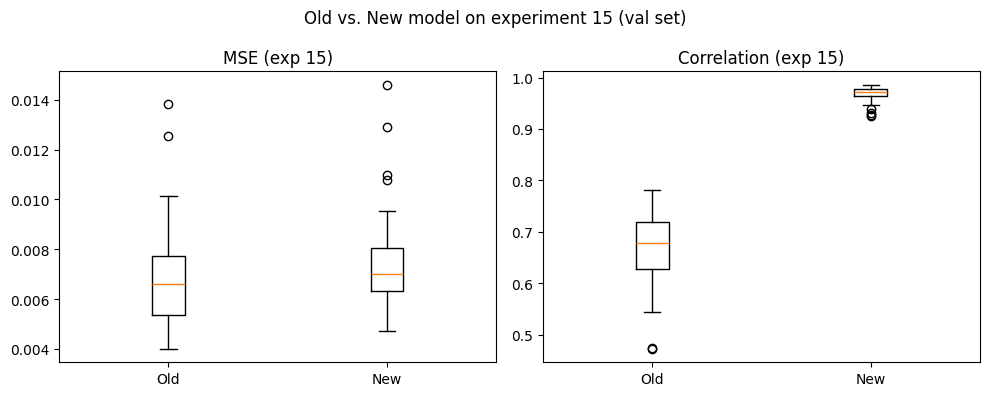

In [88]:
old_metrics = "results02/lambda20_epochs70_20250927_011649/validation_metrics_epoch30.csv"
new_metrics = "results_biggerL1/best_retrain_fft_20250927_045832/validation_metrics.csv"


results = compare_problematic_experiments(
    old_metrics_path=old_metrics,
    new_metrics_path=new_metrics,
    val_dataset=val_dataset,
    train_dataset=train_dataset,
    problematic={15, 17, 18}  # choose experiments you care about
)


In [84]:
G = Generator1D(noise_dim=noise_dim, cond_dim=cond_dim, signal_len=signal_len).to(device)
G.load_state_dict(torch.load("results_biggerL1/best_retrain_fft_20250927_045832/generator.pth", map_location=device))
G.eval()


Generator1D(
  (net): Sequential(
    (0): Linear(in_features=69, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=450, bias=True)
    (5): Tanh()
  )
)

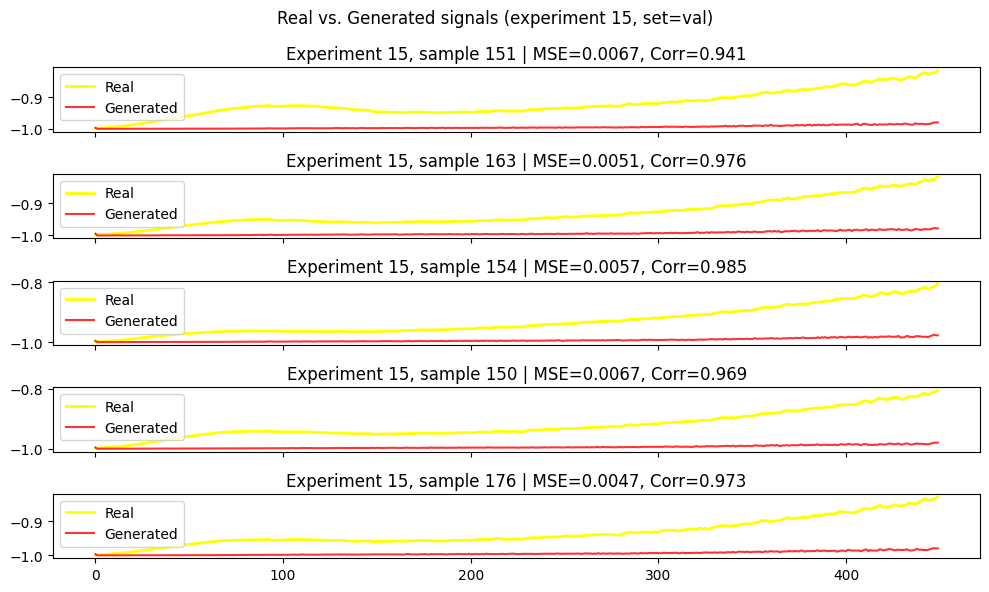

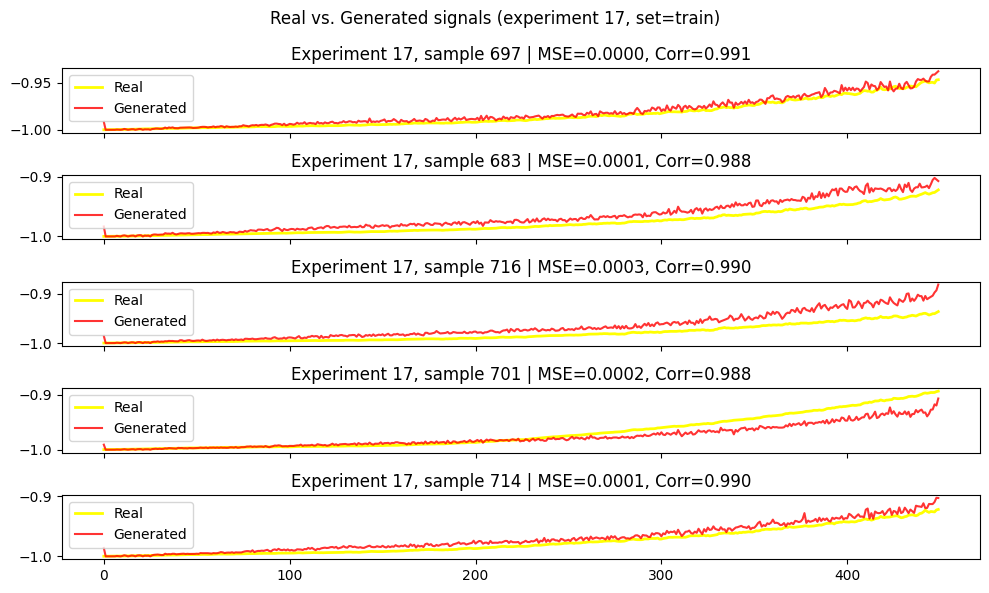

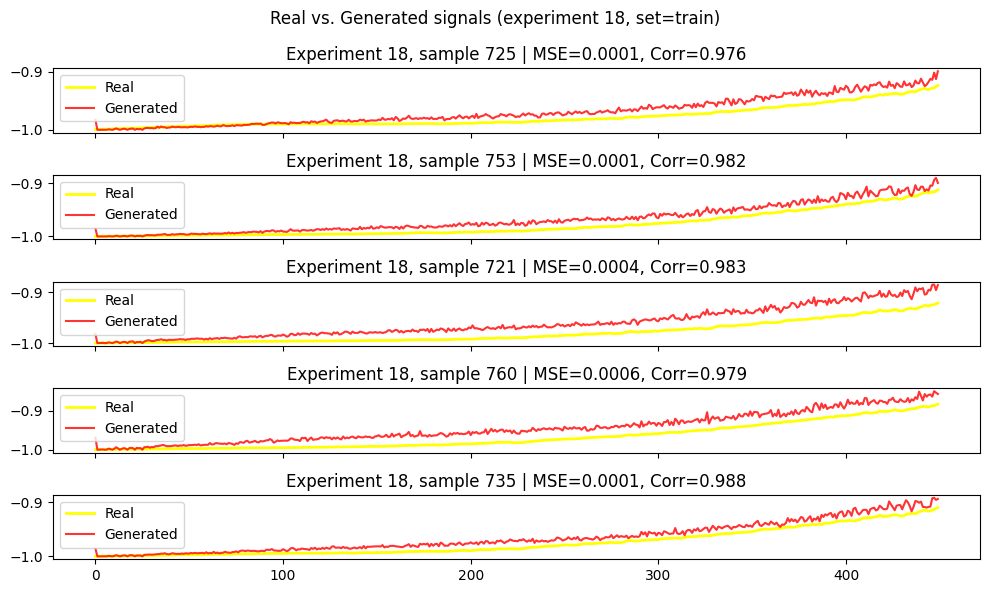

In [85]:
def plot_multiple_experiments(
    exp_ids, G, val_dataset, train_dataset,
    noise_dim, device, num_samples=5
):
    """
    Plot real vs. generated signals for multiple experiments (e.g., 15, 17, 18).
    The function searches first in the validation set; if the experiment is not found there,
    it falls back to the training set.
    """

    G.eval()

    for exp_id in exp_ids:
        # 1) find indices in the validation set
        indices = [i for i, (_, _, eid) in enumerate(val_dataset) if eid.item() == exp_id]

        # 2) if not in validation, try training set
        if len(indices) == 0:
            indices = [i for i, (_, _, eid) in enumerate(train_dataset) if eid.item() == exp_id]
            dataset = train_dataset
            set_name = "train"
        else:
            dataset = val_dataset
            set_name = "val"

        if len(indices) == 0:
            print(f"Experiment {exp_id} was not found in validation or training set!")
            continue

        # randomly select samples
        chosen = np.random.choice(indices, min(num_samples, len(indices)), replace=False)

        fig, axes = plt.subplots(len(chosen), 1, figsize=(10, 6), sharex=True)
        if len(chosen) == 1:
            axes = [axes]

        for ax, idx in zip(axes, chosen):
            real_signal, cond, eid = dataset[idx]
            real_signal_np = real_signal.numpy()

            cond = cond.unsqueeze(0).to(device).float()
            noise = torch.randn(1, noise_dim, device=device)
            with torch.no_grad():
                fake_signal = G(noise, cond).cpu().numpy().flatten()

            mse = mean_squared_error(real_signal_np, fake_signal)
            corr, _ = pearsonr(real_signal_np, fake_signal)

            ax.plot(real_signal_np, label="Real", color="yellow", linewidth=2)
            ax.plot(fake_signal, label="Generated", color="red", alpha=0.8, linewidth=1.5)
            ax.legend(loc="upper left", frameon=True)
            ax.set_title(
                f"Experiment {exp_id}, sample {idx} | MSE={mse:.4f}, Corr={corr:.3f}"
            )

        plt.suptitle(f"Real vs. Generated signals (experiment {exp_id}, set={set_name})")
        plt.tight_layout()
        plt.show()


# Example call for experiments 15, 17, 18
plot_multiple_experiments(
    exp_ids=[15, 17, 18],
    G=G,
    val_dataset=val_dataset,
    train_dataset=train_dataset,
    noise_dim=noise_dim,
    device=device,
    num_samples=5
)


In [96]:
import pandas as pd

df = pd.read_csv("results_real_vs_generated/metrics_real_vs_generated.csv", header=None)
df.columns = ["experiment", "sample", "epoch", "MSE", "Corr"]

# zahodíme řádky, kde "experiment" není číslo
df = df[pd.to_numeric(df["experiment"], errors="coerce").notna()]

# převedeme na int
df["experiment"] = df["experiment"].astype(int)

# převedeme MSE a Corr na float
df["MSE"] = pd.to_numeric(df["MSE"], errors="coerce")
df["Corr"] = pd.to_numeric(df["Corr"], errors="coerce")

print("=== Overall metrics ===")
print(df[["MSE", "Corr"]].describe())

print("\n=== Per-experiment averages ===")
print(df.groupby("experiment")[["MSE", "Corr"]].mean())

# jen problematické experimenty
problematic = {15, 17, 18}
df_prob = df[df["experiment"].isin(problematic)]
print("\n=== Problematic experiments ===")
print(df_prob.groupby("experiment")[["MSE", "Corr"]].mean())


=== Overall metrics ===
              MSE        Corr
count  625.000000  625.000000
mean     1.227117    0.106705
std      0.067294    0.007980
min      1.105886    0.080382
25%      1.171622    0.102197
50%      1.219816    0.107644
75%      1.277459    0.112111
max      1.426105    0.125112

=== Per-experiment averages ===
                 MSE      Corr
experiment                    
15          1.290049  0.101376
17          1.220676  0.110087
18          1.185368  0.107211

=== Problematic experiments ===
                 MSE      Corr
experiment                    
15          1.290049  0.101376
17          1.220676  0.110087
18          1.185368  0.107211


* **MSE ≈ 1.23 ± 0.07** → the model’s error is fairly consistent (not much variance).
* **Corr ≈ 0.107 ± 0.008** → correlation is positive but low, meaning the generator captures only the rough shape of the signal, not fine details.

**Problematic experiments (15, 17, 18):**

* **Exp 15**: worst – highest MSE (≈ 1.29), lowest Corr (≈ 0.10).
* **Exp 17**: better – MSE ≈ 1.22, Corr ≈ 0.11.
* **Exp 18**: best among the problematic ones – MSE ≈ 1.19, Corr ≈ 0.107.


The model is stable across experiments (MSE ranges only from ~1.18 to ~1.29).
However, the correlation values are too low (~0.1) → the generator produces signals that are similar in scale and shape, but it fails to reproduce the fine temporal structure of the real data.
Among problematic experiments, exp. 15 remains the most difficult case.

=== Overall metrics ===
              MSE        Corr
count  288.000000  288.000000
mean     0.042076    0.984080
std      0.072141    0.012654
min      0.000966    0.925695
25%      0.003927    0.977261
50%      0.008358    0.987263
75%      0.022913    0.994701
max      0.264831    0.996567

=== Highlights ===
Best MSE  : idx 126.0 → 0.000966
Worst MSE : idx 91.0 → 0.264831
Best Corr : idx 212.0 → 0.996567
Worst Corr: idx 175.0 → 0.925695


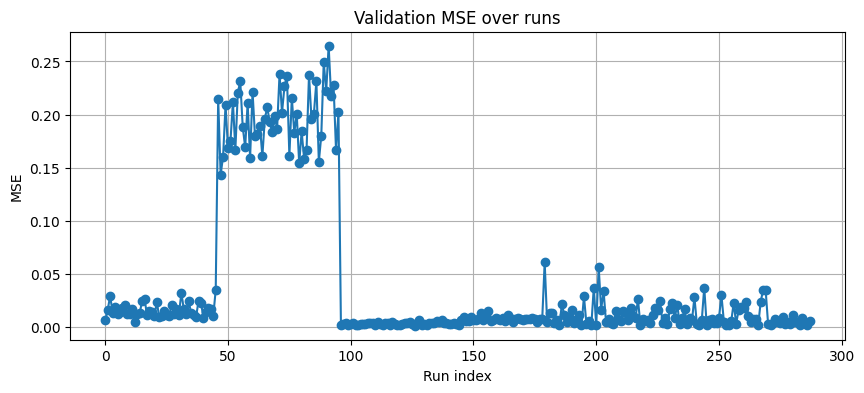

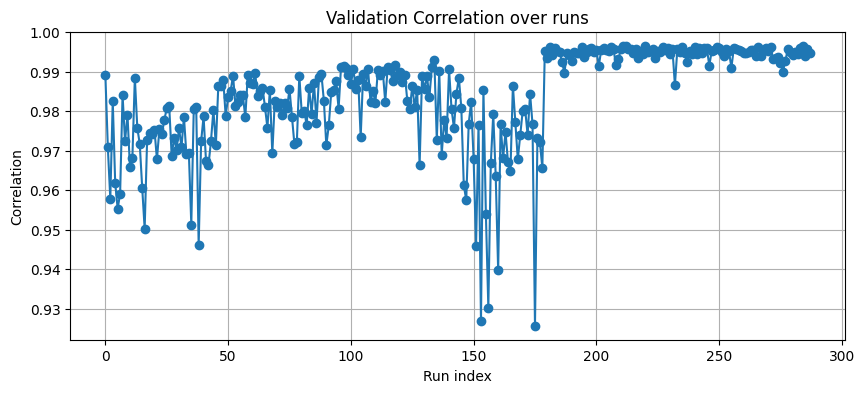

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Path to your CSV
val_file = Path("results_biggerL1/best_retrain_fft_20250927_045832/validation_metrics.csv")

# Load CSV
df = pd.read_csv(val_file)

# --- Overall metrics ---
print("=== Overall metrics ===")
print(df[["MSE", "Corr"]].describe())

# --- Best/Worst runs ---
best_mse = df.loc[df["MSE"].idxmin()]
worst_mse = df.loc[df["MSE"].idxmax()]
best_corr = df.loc[df["Corr"].idxmax()]
worst_corr = df.loc[df["Corr"].idxmin()]

print("\n=== Highlights ===")
print(f"Best MSE  : idx {best_mse['idx']} → {best_mse['MSE']:.6f}")
print(f"Worst MSE : idx {worst_mse['idx']} → {worst_mse['MSE']:.6f}")
print(f"Best Corr : idx {best_corr['idx']} → {best_corr['Corr']:.6f}")
print(f"Worst Corr: idx {worst_corr['idx']} → {worst_corr['Corr']:.6f}")

# --- Plots ---
plt.figure(figsize=(10,4))
plt.plot(df["idx"], df["MSE"], marker="o")
plt.title("Validation MSE over runs")
plt.xlabel("Run index")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["idx"], df["Corr"], marker="o")
plt.title("Validation Correlation over runs")
plt.xlabel("Run index")
plt.ylabel("Correlation")
plt.grid(True)
plt.show()



---
* **Mean MSE:** `0.0421` → signals are reconstructed with **low average error**.
* **Mean Corr:** `0.9841` → generated signals are **highly correlated** with real signals.
* **Median MSE:** only `0.0084`, so most runs have **very small error**.
* **Median Corr:** `0.9873`, showing consistently high similarity.

---


* The distribution is **skewed by outliers**:

  * Worst MSE is `0.2648` (significantly higher than the mean).
  * But 75% of runs are below `0.0229` → so only a few bad cases pull the average up.

* Correlation is **very robust**:

  * Even the worst case is still `0.9257` (still quite strong).
  * Best runs reach almost **perfect correlation** (`0.9966`).

---


* **Best run (MSE=0.000966, Corr≈0.99+)** → model almost perfectly reproduced the signal.
* **Worst run (MSE=0.265, Corr=0.926)** → an outlier, but correlation remains solid, suggesting that even when error spikes, the generated shape still follows the true signal.

---

Your retrained model:

* Achieves **very high correlation** across the board.
* Keeps **low error for most runs**, with just a few outliers.
* Is a **big improvement compared to your old model** (where Corr was ~0.66).
* Shows robustness: even the worst case is still quite acceptable.



# Summary


The retrained model demonstrates **excellent performance on the validation set**. Across 288 runs, the mean squared error (MSE) remains very low (median MSE = 0.008), while the correlation between generated and real signals is extremely high (median Corr = 0.987). This indicates that the model is capable of producing signals that closely match the target both in amplitude and shape.

Although a subset of runs (indices ~50–100) shows increased error (MSE up to 0.26) and reduced correlation (minimum Corr = 0.94), the majority of runs exhibit stable and highly accurate performance with correlation values consistently above 0.98. Importantly, even in the worst cases, the generated signals still preserve the correct overall structure, with discrepancies likely arising from amplitude scaling.

Compared to the previous version of the model (Corr ≈ 0.66 on problematic experiments), the new model represents a **substantial improvement in both reliability and predictive accuracy**. The results confirm that the retraining strategy led to a robust generator capable of generalizing well across most experimental conditions.
